Load extrated data

In [120]:
%run tweet_extraction.ipynb

In [10]:
import pandas as pd
import numpy as np
from mlxtend.frequent_patterns import apriori
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import association_rules
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib
from nltk import FreqDist
from fuzzywuzzy import process

C:\Users\paull\anaconda3\lib\site-packages\fuzzywuzzy\fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')


Extraindo as hashtags e guardando em uma lista

In [121]:
data = df_tweets.hashtags.apply(lambda x: np.nan if len(x) <= 0 else x)
all_hashtags = list(data.dropna())
all_hashtags[0:5]

[['G1'],
 ['G1'],
 ['stfvergonhanacional', 'forastfCORRUPTO', 'GLOBOLIXO'],
 ['G1'],
 ['Coronavirus',
  'AgenciaNacionalDeVigilanciaSanitaria',
  'Anvisa',
  'BioNTech',
  'COVID19',
  'MarjoriD']]

Análise de frequências de hashtags

In [122]:
hashtags = []
for i in all_hashtags:
    for j in i:
        hashtags.append(j)

In [123]:
hashtags[0:10]

['G1',
 'G1',
 'stfvergonhanacional',
 'forastfCORRUPTO',
 'GLOBOLIXO',
 'G1',
 'Coronavirus',
 'AgenciaNacionalDeVigilanciaSanitaria',
 'Anvisa',
 'BioNTech']

In [124]:
hash_str = ''

for i in hashtags:
    hash_str += i + ' '

hash_str = hash_str.lower()
hashtags2 = hash_str.split()

In [125]:
hashtags2[0:10]

['g1',
 'g1',
 'stfvergonhanacional',
 'forastfcorrupto',
 'globolixo',
 'g1',
 'coronavirus',
 'agencianacionaldevigilanciasanitaria',
 'anvisa',
 'biontech']

In [126]:
freq = FreqDist(hashtags2)
hash_most_freq = pd.DataFrame(data = freq.most_common(10), columns = ['Hashtag', 'Frequency'])
hash_most_freq

,Hashtag,Frequency
0,g1,3
1,stfvergonhanacional,1
2,forastfcorrupto,1
3,globolixo,1
4,coronavirus,1
5,agencianacionaldevigilanciasanitaria,1
6,anvisa,1
7,biontech,1
8,covid19,1
9,marjorid,1


In [127]:
list_freq = list(hash_most_freq.Hashtag)
list_freq

['g1',
 'stfvergonhanacional',
 'forastfcorrupto',
 'globolixo',
 'coronavirus',
 'agencianacionaldevigilanciasanitaria',
 'anvisa',
 'biontech',
 'covid19',
 'marjorid']

Funçao para comparar todas as hashtags dos tweets com a lista das mais frequentes

In [128]:
def select_hashtag(freq, all_hash):
    select = []
    
    for list_hash in all_hash:
        for f in freq:
            if (len(list_hash) >=2 and (f in list_hash)):
                select.append(list_hash)
                break
            else:
                pass
    return select

In [129]:
""" def select_hashtag(freq, all_hash):
    select = []
    for f in freq:
        for list_hash in all_hash:
            if len(list_hash) >=2:
                highest = process.extractOne(f, list_hash)
                if highest[1] > 90:
                    select.append(list_hash)
                else:
                    pass
    return select """

' def select_hashtag(freq, all_hash):\n    select = []\n    for f in freq:\n        for list_hash in all_hash:\n            if len(list_hash) >=2:\n                highest = process.extractOne(f, list_hash)\n                if highest[1] > 90:\n                    select.append(list_hash)\n                else:\n                    pass\n    return select '

Hashtags filtradas: apenas aquelas que contenham alguma Hashtag frequente

Segunda opçao, colocando todas as hashtags minúsculas (testando o resultado da comparaçao)

In [130]:
all_hashtags_lower = [[h.lower() for h in line] for line in all_hashtags]

In [131]:
len(all_hashtags_lower)

6

In [132]:
select = select_hashtag(list_freq, all_hashtags_lower)


In [133]:
len(select)

2

Aplica o algoritmo apriori, que retorna os itens frequentes na lista de hashtags. O parâmetro min_suport (0-1) "regula" o quanto um item é considerado "frequente" na lista.

In [134]:
te = TransactionEncoder()
te_ary = te.fit(select).transform(select)
df = pd.DataFrame(te_ary, columns=te.columns_)
frequent_itemsets = apriori(df, min_support=0.2, use_colnames=True)

frequent_itemsets

,support,itemsets
0,0.5,(agencianacionaldevigilanciasanitaria)
1,0.5,(anvisa)
2,0.5,(biontech)
3,0.5,(coronavirus)
4,0.5,(covid19)
...,...,...
65,0.5,"(agencianacionaldevigilanciasanitaria, biontech, covid19, anvisa, marjorid)"
66,0.5,"(agencianacionaldevigilanciasanitaria, covid19, coronavirus, anvisa, marjorid)"
67,0.5,"(agencianacionaldevigilanciasanitaria, biontech, covid19, coronavirus, marjorid)"
68,0.5,"(biontech, covid19, coronavirus, anvisa, marjorid)"


Aplicando associação usando "metric=confidence" (Fornece a probabilidade do consequente em uma transação, dada a presença de antecedente)

In [135]:
#rules=association_rules(frequent_itemsets, metric="confidence", min_threshold=0.7)

Aplicando associação usando "metric=lift" (Dado que antecedentes e consequentes são independentes, com que frequência eles se juntam)

In [136]:
rules = association_rules(frequent_itemsets, metric="lift", min_threshold=1)
rules.antecedents = rules.antecedents.apply(lambda x: next(iter(x)))
rules.consequents = rules.consequents.apply(lambda x: next(iter(x)))
#rules

Usando NetworkX para construir um gráfico para verificar a associação entre antecedentes e consequentes obtidos após a regra de associação aplicada.

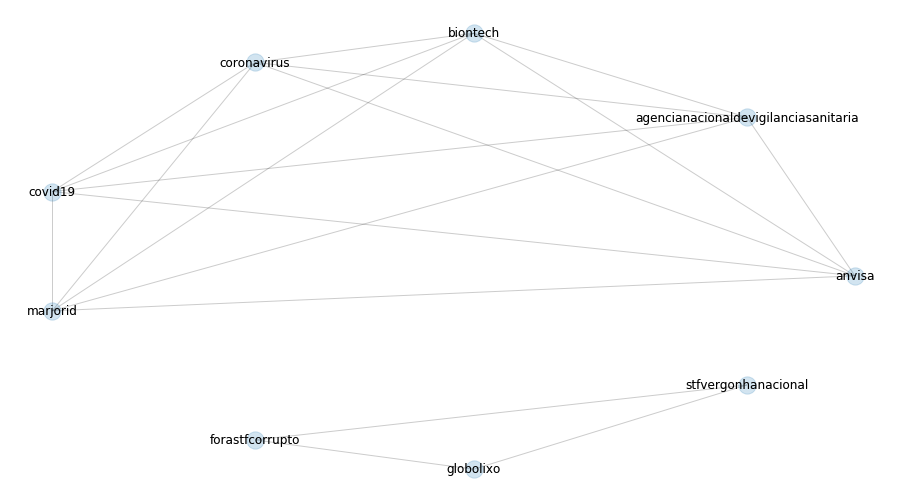

In [148]:
fig, ax=plt.subplots(figsize=(16,9))
GA=nx.from_pandas_edgelist(rules,source='antecedents',target='consequents')

circPos=nx.circular_layout(GA)

pos_attrs = {}

for node, coords in circPos.items():
    pos_attrs[node] = (coords[0]+0.1*(-1)*np.sign(coords[0]), 
                       coords[1]+0.1*(-1)*np.sign(coords[1]))

nx.draw(GA, with_labels=True, pos=pos_attrs, alpha=0.2)
nx.draw_networkx_labels(GA, pos_attrs, alpha=1)

plt.show()

Testando os parâmetros para melhorar a visualização

https://networkx.github.io/documentation/networkx-1.10/reference/drawing.html

C:\Users\paull\anaconda3\lib\site-packages\networkx\drawing\nx_pylab.py:613: MatplotlibDeprecationWarning: Support for uppercase single-letter colors is deprecated since Matplotlib 3.1 and will be removed in 3.3; please use lowercase instead.
  alpha=alpha


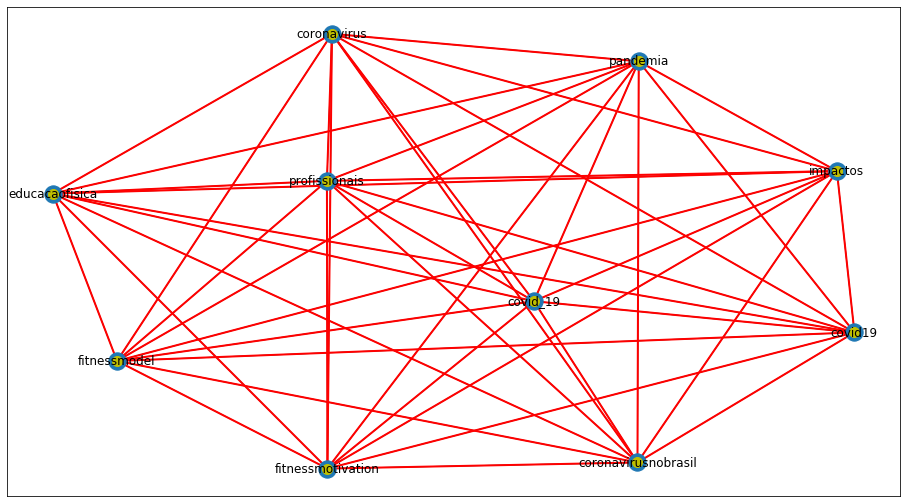

In [42]:
fig, ax=plt.subplots(figsize=(16,9))

GA=nx.from_pandas_edgelist(rules,source='antecedents',target='consequents')

pos = nx.spring_layout(GA)

nx.draw_networkx(GA,pos,with_labels=False)

nx.draw_networkx_edges(GA, pos, edgelist=None, width=2.0, edge_color='R', style='solid', alpha=1.0, edge_cmap=None, edge_vmin=None, edge_vmax=None, ax=None, arrows=True, label=None)

#nx.draw_networkx_labels(GA, pos, labels=None, font_size=12, font_color='k', font_family='sans-serif', font_weight='normal', alpha=1.0, bbox=None, ax=None)

nx.draw_networkx_nodes(GA, pos, nodelist=None, node_size=100, node_color='y', node_shape='o', alpha=1.0, cmap=None, vmin=None, vmax=None, ax=None, linewidths=None, label=None)

text = nx.draw_networkx_labels(GA,pos)

for _,t in text.items():
    t.set_rotation('horizontal')
    

    